# 201810803 장서령

In [2]:
import os
import pyspark
import pandas as pd

os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
myConf=pyspark.SparkConf()
spark=pyspark.sql.SparkSession.builder.master("local").appName("myApp").config(conf=myConf).getOrCreate()

## 문제1 : 2020년 8월 서울시 지하철호선별 역별 승하차 인원 정보
문제를 풀고 결과 출력을 예시해 놓았다. 동일하지 않아도 유사하게 출력하면 된다.

##### 1-1) DataFrame 생성하고, 스키마는 자동인식하여 출력

##### 1-1) 답

In [6]:
subwayDf = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true', delimiter=',').load(os.path.join("/FileStore/tables","CARD_SUBWAY_MONTH_202008.csv"))
subwayDf.printSchema()

root
-- 사용일자: integer (nullable = true)
-- 노선명: string (nullable = true)
-- 역ID: string (nullable = true)
-- 역명: integer (nullable = true)
-- 승차총승객수: integer (nullable = true)
-- 하차총승객수: integer (nullable = true)
-- 등록일자: string (nullable = true)

##### 1-2) 컬럼명을 변경하고, 스키마 출력

##### 1-2) 답

In [9]:
# 컬럼명 변환 및 스키마 출력
subwayDf=subwayDf.withColumnRenamed('사용일자','dateUse').withColumnRenamed('노선명','line').withColumnRenamed('역ID','stationID').withColumnRenamed('역명','station').withColumnRenamed('승차총승객수','NInPassengers').withColumnRenamed('하차총승객수','NOutPassengers').withColumnRenamed('등록일자','dateRegi')
subwayDf.printSchema()
# subwayDf.show()

root
-- dateUse: integer (nullable = true)
-- line: string (nullable = true)
-- stationID: string (nullable = true)
-- station: integer (nullable = true)
-- NInPassengers: integer (nullable = true)
-- NOutPassengers: integer (nullable = true)
-- dateRegi: string (nullable = true)

##### 1-3) 노선별 승하차합계가 가장 높은 역을 출력 (모든 노선 출력)

In [11]:
# Date컬럼 추가 후, 내용은 dateUse의 데이터를 String 형태로 가져오기
_subwayDf = subwayDf.withColumn('Date', subwayDf['dateUse'].cast("String"))
_subwayDf.printSchema()

root
-- dateUse: integer (nullable = true)
-- line: string (nullable = true)
-- stationID: string (nullable = true)
-- station: integer (nullable = true)
-- NInPassengers: integer (nullable = true)
-- NOutPassengers: integer (nullable = true)
-- dateRegi: string (nullable = true)
-- Date: string (nullable = true)

In [12]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DateType
from datetime import datetime

#yyyy-mm-dd 형태로 출력하기
toDate = udf(lambda x: datetime.strptime(x, '%Y%m%d'), DateType())
_subwayDf = _subwayDf.withColumn('Date', toDate(_subwayDf['Date']))
_subwayDf.show(10)

+--------+------+-----------------------+-------+-------------+--------------+--------+----------+
 dateUse| line| stationID|station|NInPassengers|NOutPassengers|dateRegi| Date|
+--------+------+-----------------------+-------+-------------+--------------+--------+----------+
20200801|중앙선| 오빈| 249| 239| 20200804| null|2020-08-01|
20200801|중앙선| 아신| 467| 595| 20200804| null|2020-08-01|
20200801|중앙선| 국수| 520| 598| 20200804| null|2020-08-01|
20200801| 2호선| 한양대| 3244| 3022| 20200804| null|2020-08-01|
20200801| 2호선| 왕십리(성동구청)| 11110| 9769| 20200804| null|2020-08-01|
20200801| 2호선| 상왕십리| 8110| 7289| 20200804| null|2020-08-01|
20200801| 2호선| 신당| 8703| 8731| 20200804| null|2020-08-01|
20200801| 2호선|동대문역사문화공원(DDP)| 8183| 8474| 20200804| null|2020-08-01|
20200801| 2호선| 을지로4가| 5103| 5207| 20200804| null|2020-08-01|
20200801| 2호선| 을지로3가| 7714| 7826| 20200804| null|2020-08-01|
+--------+------+-----------------------+-------+-------------+--------------+--------+----------+
only showing top 10 rows

In [13]:
# 승하차인원 합하기 (SumInOut 컬럼 추가)
_subwayDf = _subwayDf.withColumn('SumInOut',(_subwayDf['NInPassengers']+_subwayDf['NOutPassengers']))
_subwayDf.show()

+--------+------+-----------------------+-------+-------------+--------------+--------+----------+--------+
 dateUse| line| stationID|station|NInPassengers|NOutPassengers|dateRegi| Date|SumInOut|
+--------+------+-----------------------+-------+-------------+--------------+--------+----------+--------+
20200801|중앙선| 오빈| 249| 239| 20200804| null|2020-08-01|20201043|
20200801|중앙선| 아신| 467| 595| 20200804| null|2020-08-01|20201399|
20200801|중앙선| 국수| 520| 598| 20200804| null|2020-08-01|20201402|
20200801| 2호선| 한양대| 3244| 3022| 20200804| null|2020-08-01|20203826|
20200801| 2호선| 왕십리(성동구청)| 11110| 9769| 20200804| null|2020-08-01|20210573|
20200801| 2호선| 상왕십리| 8110| 7289| 20200804| null|2020-08-01|20208093|
20200801| 2호선| 신당| 8703| 8731| 20200804| null|2020-08-01|20209535|
20200801| 2호선|동대문역사문화공원(DDP)| 8183| 8474| 20200804| null|2020-08-01|20209278|
20200801| 2호선| 을지로4가| 5103| 5207| 20200804| null|2020-08-01|20206011|
20200801| 2호선| 을지로3가| 7714| 7826| 20200804| null|2020-08-01|20208630|
20200801| 2호선| 을지로입구| 17597| 17387| 20200804| null|2020-08-01|20218191|
20200801| 2호선| 시청| 5908| 5313| 20200804| null|2020-08-01|20206117|
20200801| 1호선| 청량리(서울시립대입구)| 15186| 15126| 20200804| null|2020-08-01|20215930|
20200801| 1호선| 제기동| 10652| 10614| 20200804| null|2020-08-01|20211418|
20200801| 1호선| 신설동| 7507| 7209| 20200804| null|2020-08-01|20208013|
20200801| 1호선| 동대문| 9290| 9591| 20200804| null|2020-08-01|20210395|
20200801| 1호선| 종로5가| 14190| 14490| 20200804| null|2020-08-01|20215294|
20200801| 1호선| 종로3가| 17935| 17664| 20200804| null|2020-08-01|20218468|
20200801| 1호선| 종각| 16751| 16845| 20200804| null|2020-08-01|20217649|
20200801|안산선| 정왕| 4547| 4651| 20200804| null|2020-08-01|20205455|
+--------+------+-----------------------+-------+-------------+--------------+--------+----------+--------+
only showing top 20 rows

In [14]:
# window 함수
from pyspark.sql.window import Window
winF=Window.partitionBy("line").orderBy(F.col("SumInOut").desc())

##### 1-3) 답

In [16]:
from pyspark.sql.functions import rank
_subwayDf=_subwayDf.withColumn("rank", rank().over(winF))
#_subwayDf.filter(_subwayDf.rank == 1).show()
_subwayDf.filter(_subwayDf.rank == 1).sort("SumInOut").show()
# 왜 정렬이 안될까요 의문입니다 ..... 

+--------+--------------+--------------------+-------+-------------+--------------+--------+----------+--------+----+
 dateUse| line| stationID|station|NInPassengers|NOutPassengers|dateRegi| Date|SumInOut|rank|
+--------+--------------+--------------------+-------+-------------+--------------+--------+----------+--------+----+
20200814| 장항선| 온양온천| 4528| 4534| 20200817| null|2020-08-14|20205351| 1|
20200812| 우이신설선| 북한산보국문| 5432| 5200| 20200815| null|2020-08-12|20206015| 1|
20200812| 수인선| 인천논현| 5428| 5761| 20200815| null|2020-08-12|20206576| 1|
20200807| 경춘선| 평내호평| 5904| 5788| 20200810| null|2020-08-07|20206598| 1|
20200813| 경강선| 경기광주| 7042| 6561| 20200816| null|2020-08-13|20207377| 1|
20200813| 경의선| 일산| 9812| 9629| 20200816| null|2020-08-13|20210445| 1|
20200811|공항철도 1호선| 디지털미디어시티| 14311| 13310| 20200814| null|2020-08-11|20214124| 1|
20200807| 안산선| 산본| 16478| 17897| 20200810| null|2020-08-07|20218707| 1|
20200807| 일산선| 화정| 17591| 17916| 20200810| null|2020-08-07|20218726| 1|
20200814| 9호선2~3단계| 봉은사| 19184| 19435| 20200817| null|2020-08-14|20220252| 1|
20200807| 6호선| 공덕| 19817| 19484| 20200810| null|2020-08-07|20220294| 1|
20200807| 경원선| 의정부| 18455| 20025| 20200810| null|2020-08-07|20220835| 1|
20200810| 8호선| 문정| 21546| 22525| 20200813| null|2020-08-10|20223338| 1|
20200807| 중앙선| 회기| 24548| 23474| 20200810| null|2020-08-07|20224284| 1|
20200807| 과천선| 범계| 26478| 26718| 20200810| null|2020-08-07|20227528| 1|
20200814| 분당선| 야탑| 25876| 27587| 20200817| null|2020-08-14|20228404| 1|
20200812| 4호선| 혜화| 34232| 35109| 20200815| null|2020-08-12|20235924| 1|
20200814| 경인선| 부평| 31226| 35539| 20200817| null|2020-08-14|20236356| 1|
20200807| 9호선| 신논현| 35701| 38782| 20200810| null|2020-08-07|20239592| 1|
20200815| 5호선|광화문(세종문화회관)| 39181| 39792| 20200818| null|2020-08-15|20240610| 1|
+--------+--------------+--------------------+-------+-------------+--------------+--------+----------+--------+----+
only showing top 20 rows

In [17]:
from pyspark.sql.functions import row_number
_subwayDf=_subwayDf.withColumn("row_number",row_number().over(winF))
_subwayDf.filter(_subwayDf.rank == 1).show()

+--------+--------------+--------------------+-------+-------------+--------------+--------+----------+--------+----+----------+
 dateUse| line| stationID|station|NInPassengers|NOutPassengers|dateRegi| Date|SumInOut|rank|row_number|
+--------+--------------+--------------------+-------+-------------+--------------+--------+----------+--------+----+----------+
20200814| 1호선| 서울역| 46822| 49099| 20200817| null|2020-08-14|20249916| 1| 1|
20200807| 2호선| 강남| 98692| 104043| 20200810| null|2020-08-07|20304853| 1| 1|
20200814| 3호선| 고속터미널| 49312| 57842| 20200817| null|2020-08-14|20258659| 1| 1|
20200812| 4호선| 혜화| 34232| 35109| 20200815| null|2020-08-12|20235924| 1| 1|
20200815| 5호선|광화문(세종문화회관)| 39181| 39792| 20200818| null|2020-08-15|20240610| 1| 1|
20200807| 6호선| 공덕| 19817| 19484| 20200810| null|2020-08-07|20220294| 1| 1|
20200812| 7호선| 가산디지털단지| 46117| 46836| 20200815| null|2020-08-12|20247651| 1| 1|
20200810| 8호선| 문정| 21546| 22525| 20200813| null|2020-08-10|20223338| 1| 1|
20200807| 9호선| 신논현| 35701| 38782| 20200810| null|2020-08-07|20239592| 1| 1|
20200814| 9호선2~3단계| 봉은사| 19184| 19435| 20200817| null|2020-08-14|20220252| 1| 1|
20200813| 경강선| 경기광주| 7042| 6561| 20200816| null|2020-08-13|20207377| 1| 1|
20200807| 경부선| 영등포| 43168| 46982| 20200810| null|2020-08-07|20247792| 1| 1|
20200807| 경원선| 의정부| 18455| 20025| 20200810| null|2020-08-07|20220835| 1| 1|
20200813| 경의선| 일산| 9812| 9629| 20200816| null|2020-08-13|20210445| 1| 1|
20200814| 경인선| 부평| 31226| 35539| 20200817| null|2020-08-14|20236356| 1| 1|
20200807| 경춘선| 평내호평| 5904| 5788| 20200810| null|2020-08-07|20206598| 1| 1|
20200811|공항철도 1호선| 디지털미디어시티| 14311| 13310| 20200814| null|2020-08-11|20214124| 1| 1|
20200807| 과천선| 범계| 26478| 26718| 20200810| null|2020-08-07|20227528| 1| 1|
20200814| 분당선| 야탑| 25876| 27587| 20200817| null|2020-08-14|20228404| 1| 1|
20200812| 수인선| 인천논현| 5428| 5761| 20200815| null|2020-08-12|20206576| 1| 1|
+--------+--------------+--------------------+-------+-------------+--------------+--------+----------+--------+----+----------+
only showing top 20 rows

##### 1-4) 노선별 요일별 승하차인원 합계 (모든 노선 출력)

In [19]:
_subwayDf=_subwayDf.drop('rank').drop('row_number')
_subwayDf=_subwayDf.withColumn("date_dd",_subwayDf.dateUse.substr(7,8))
_subwayDf = _subwayDf.withColumn('date_dd', _subwayDf['date_dd'].cast("integer"))
_subwayDf.show(10)

+--------+------+-----------------------+-------+-------------+--------------+--------+----------+--------+-------+
 dateUse| line| stationID|station|NInPassengers|NOutPassengers|dateRegi| Date|SumInOut|date_dd|
+--------+------+-----------------------+-------+-------------+--------------+--------+----------+--------+-------+
20200801|중앙선| 오빈| 249| 239| 20200804| null|2020-08-01|20201043| 1|
20200801|중앙선| 아신| 467| 595| 20200804| null|2020-08-01|20201399| 1|
20200801|중앙선| 국수| 520| 598| 20200804| null|2020-08-01|20201402| 1|
20200801| 2호선| 한양대| 3244| 3022| 20200804| null|2020-08-01|20203826| 1|
20200801| 2호선| 왕십리(성동구청)| 11110| 9769| 20200804| null|2020-08-01|20210573| 1|
20200801| 2호선| 상왕십리| 8110| 7289| 20200804| null|2020-08-01|20208093| 1|
20200801| 2호선| 신당| 8703| 8731| 20200804| null|2020-08-01|20209535| 1|
20200801| 2호선|동대문역사문화공원(DDP)| 8183| 8474| 20200804| null|2020-08-01|20209278| 1|
20200801| 2호선| 을지로4가| 5103| 5207| 20200804| null|2020-08-01|20206011| 1|
20200801| 2호선| 을지로3가| 7714| 7826| 20200804| null|2020-08-01|20208630| 1|
+--------+------+-----------------------+-------+-------------+--------------+--------+----------+--------+-------+
only showing top 10 rows

In [20]:
# 날짜에 맞게 요일 범위 나누기, udf 함수 제작
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
def classifyWeek(date):
    #_day = int(date)
    day = int(date % 7)
    if day == 6:
        q = 'Thursday'
    elif day == 0:
        q = 'Friday'
    elif day == 1:
        q = 'Saturday'
    elif day == 2:
        q = "Sunday"
    elif day == 3:
        q = "Monday"
    elif day == 4:
        q = "Tuesday"
    elif day == 5:
        q = "Wednesday"
    return q

In [21]:
week_udf = udf(classifyWeek, StringType())
_subwayDf=_subwayDf.withColumn("Week", week_udf(_subwayDf.date_dd))
_subwayDf.show(10)

+--------+------+-----------------------+-------+-------------+--------------+--------+----------+--------+-------+--------+
 dateUse| line| stationID|station|NInPassengers|NOutPassengers|dateRegi| Date|SumInOut|date_dd| Week|
+--------+------+-----------------------+-------+-------------+--------------+--------+----------+--------+-------+--------+
20200801|중앙선| 오빈| 249| 239| 20200804| null|2020-08-01|20201043| 1|Saturday|
20200801|중앙선| 아신| 467| 595| 20200804| null|2020-08-01|20201399| 1|Saturday|
20200801|중앙선| 국수| 520| 598| 20200804| null|2020-08-01|20201402| 1|Saturday|
20200801| 2호선| 한양대| 3244| 3022| 20200804| null|2020-08-01|20203826| 1|Saturday|
20200801| 2호선| 왕십리(성동구청)| 11110| 9769| 20200804| null|2020-08-01|20210573| 1|Saturday|
20200801| 2호선| 상왕십리| 8110| 7289| 20200804| null|2020-08-01|20208093| 1|Saturday|
20200801| 2호선| 신당| 8703| 8731| 20200804| null|2020-08-01|20209535| 1|Saturday|
20200801| 2호선|동대문역사문화공원(DDP)| 8183| 8474| 20200804| null|2020-08-01|20209278| 1|Saturday|
20200801| 2호선| 을지로4가| 5103| 5207| 20200804| null|2020-08-01|20206011| 1|Saturday|
20200801| 2호선| 을지로3가| 7714| 7826| 20200804| null|2020-08-01|20208630| 1|Saturday|
+--------+------+-----------------------+-------+-------------+--------------+--------+----------+--------+-------+--------+
only showing top 10 rows

##### 1-4) 답

In [23]:
_subwayDf.groupBy('line').pivot('Week').agg({"SumInOut":"sum"}).show()

+----------+----------+----------+----------+----------+----------+----------+----------+
 line| Friday| Monday| Saturday| Sunday| Thursday| Tuesday| Wednesday|
+----------+----------+----------+----------+----------+----------+----------+----------+
 일산선| 808395124|1010437381|1010319451|1010235636| 808383940| 808393127| 808392796|
 장항선| 484860929| 606069487| 606063946| 606058420| 484854907| 484857571| 484857468|
 경부선|3152874143|3940824196|3940449561|3940133615|3152768029|3152789327|3152794978|
우이신설선|1050583774|1313216004|1313167396|1313141053|1050582715|1050586483|1050587942|
 분당선|2809238836|3435543817|3455281248|3434771069|2788970586|2789009658|2768803828|
 7호선|4123433410|5153934706|5152897879|5152372864|4123394044|4123436711|4123433745|
 수인선|1050588760|1313214661|1313171127|1313138823|1050582601|1050584965|1050586007|
 안산선|1050846248|1313503526|1313393601|1313300973|1050826620|1050840359|1050838751|
 4호선|2102629179|2627972877|2627425802|2627003684|2102581482|2102588996|2102590630|
 1호선| 808840770|1010902468|1010677910|1010442174| 808804370| 808813210| 808797690|
 경의선|2141642803|2646697558|2646561932|2646494734|2121429983|2121436128|2121433286|
 3호선|2708784505|3415913093|3354722587|3374445602|2688499281|2708723859|2708711680|
 경강선| 888930088|1090945973|1111121523|1111105700| 888923196| 868723718| 888926255|
 경춘선|1535387760|1919221212|1919196396|1919167433|1535380993|1535382747|1535383086|
 9호선|2021107122|2526177609|2525784137|2525583827|2021068190|2021074069|2021062632|
 6호선|3031250674|3798984557|3798594037|3818552063|3091829677|3031240634|3031242266|
 5호선|4244326342|5315167094|5314273162|5313799053|4244300204|4244334032|4244325671|
 8호선|1374322875|1717805968|1717544282|1717409954|1374304672|1374321055|1374320670|
 과천선| 646761679| 808392943| 808256281| 808185423| 646752103| 646758203| 646760792|
 경인선|1617072711|2021192027|2020923212|2020665884|1617026950|1617048535|1617052844|
+----------+----------+----------+----------+----------+----------+----------+----------+
only showing top 20 rows

##### 1-5) 노선별 요일별 승하차인원 그래프

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# 노선별, 요일별 데이터프레임 생성
sub_weekDf=_subwayDf.groupBy('line').pivot('Week').agg({"SumInOut":"sum"})
sub_week_Pan = sub_weekDf.toPandas()

In [26]:
sub_week_Pan.index=sub_week_Pan['line']
sub_week_Pan.drop(['line'], axis='columns', inplace=True)
sub_week_Pan

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
line,,,,,,,
일산선,808395124,1010437381,1010319451,1010235636,808383940,808393127,808392796
장항선,484860929,606069487,606063946,606058420,484854907,484857571,484857468
경부선,3152874143,3940824196,3940449561,3940133615,3152768029,3152789327,3152794978
우이신설선,1050583774,1313216004,1313167396,1313141053,1050582715,1050586483,1050587942
분당선,2809238836,3435543817,3455281248,3434771069,2788970586,2789009658,2768803828
7호선,4123433410,5153934706,5152897879,5152372864,4123394044,4123436711,4123433745
수인선,1050588760,1313214661,1313171127,1313138823,1050582601,1050584965,1050586007
안산선,1050846248,1313503526,1313393601,1313300973,1050826620,1050840359,1050838751
4호선,2102629179,2627972877,2627425802,2627003684,2102581482,2102588996,2102590630


In [27]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumMyeongjo')
#plt.barh(range(len(v)), v, color = 'black')
#plt.yticks(range(len(v)), k)
#plt.show()

In [28]:
from matplotlib import font_manager
for font in font_manager.fontManager.ttflist:
    if 'Myeongjo' in font.name:
        print(font.name, font.fname)

##### 1-5) 답

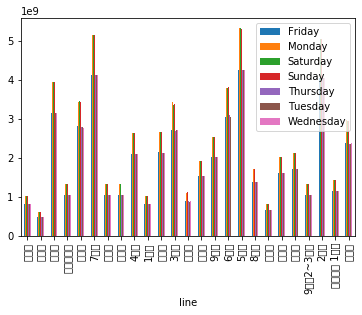

In [30]:
sub_week_Pan.plot(kind='bar') 
plt.show()

## 문제2 : 한국의 코로나바이러스

데이터는 TimeProvince.csv를 다운로드해서 사용한다.
문제를 풀고 결과 출력을 예시해 놓았다. 동일하지 않아도 유사하게 출력하면 된다.

##### 2-1) DataFrame 생성하고, 자동인식한 스키마를 출력

##### 2-1) 답

In [34]:
coronaDf= spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true', delimiter=',').load(os.path.join("/FileStore/tables","TimeProvince.csv"))
coronaDf.printSchema()

root
-- date: string (nullable = true)
-- time: integer (nullable = true)
-- province: string (nullable = true)
-- confirmed: integer (nullable = true)
-- released: integer (nullable = true)
-- deceased: integer (nullable = true)

In [35]:
coronaDf.show(3)

+----------+----+--------+---------+--------+--------+
 date|time|province|confirmed|released|deceased|
+----------+----+--------+---------+--------+--------+
2020-01-20| 16| Seoul| 0| 0| 0|
2020-01-20| 16| Busan| 0| 0| 0|
2020-01-20| 16| Daegu| 0| 0| 0|
+----------+----+--------+---------+--------+--------+
only showing top 3 rows

##### 2-2) 3월의 데이터만 출력

In [37]:
from pyspark.sql.functions import split
split_col = split(coronaDf['date'], '-')

In [38]:
corona_splitmon=coronaDf.withColumn('month', split_col.getItem(1))
corona_splitmon.show(5)

+----------+----+--------+---------+--------+--------+-----+
 date|time|province|confirmed|released|deceased|month|
+----------+----+--------+---------+--------+--------+-----+
2020-01-20| 16| Seoul| 0| 0| 0| 01|
2020-01-20| 16| Busan| 0| 0| 0| 01|
2020-01-20| 16| Daegu| 0| 0| 0| 01|
2020-01-20| 16| Incheon| 1| 0| 0| 01|
2020-01-20| 16| Gwangju| 0| 0| 0| 01|
+----------+----+--------+---------+--------+--------+-----+
only showing top 5 rows

##### 2-2) 답

In [40]:
corona_splitmon.filter(corona_splitmon.month == 3).show()
#corona_splitmon=corona_splitmon.drop('month').show()

+----------+----+-----------------+---------+--------+--------+-----+
 date|time| province|confirmed|released|deceased|month|
+----------+----+-----------------+---------+--------+--------+-----+
2020-03-01| 16| Seoul| 87| 11| 0| 03|
2020-03-01| 16| Busan| 83| 0| 0| 03|
2020-03-01| 16| Daegu| 2704| 6| 11| 03|
2020-03-01| 16| Incheon| 6| 1| 0| 03|
2020-03-01| 16| Gwangju| 9| 2| 0| 03|
2020-03-01| 16| Daejeon| 13| 0| 0| 03|
2020-03-01| 16| Ulsan| 20| 0| 0| 03|
2020-03-01| 16| Sejong| 1| 0| 0| 03|
2020-03-01| 16| Gyeonggi-do| 89| 8| 1| 03|
2020-03-01| 16| Gangwon-do| 15| 0| 0| 03|
2020-03-01| 16|Chungcheongbuk-do| 11| 0| 0| 03|
2020-03-01| 16|Chungcheongnam-do| 68| 0| 0| 03|
2020-03-01| 16| Jeollabuk-do| 6| 1| 0| 03|
2020-03-01| 16| Jeollanam-do| 3| 0| 0| 03|
2020-03-01| 16| Gyeongsangbuk-do| 556| 1| 6| 03|
2020-03-01| 16| Gyeongsangnam-do| 63| 1| 0| 03|
2020-03-01| 16| Jeju-do| 2| 0| 0| 03|
2020-03-02| 0| Seoul| 91| 12| 0| 03|
2020-03-02| 0| Busan| 88| 1| 0| 03|
2020-03-02| 0| Daegu| 3081| 7| 15| 03|
+----------+----+-----------------+---------+--------+--------+-----+
only showing top 20 rows

##### 2-3) 년x월별 건수

In [42]:
# 년도, 월별 컬럼 추가하기
corona_splitmon=coronaDf.withColumn('year', split_col.getItem(0)).withColumn('month', split_col.getItem(1))
corona_splitmon.show()

+----------+----+-----------------+---------+--------+--------+----+-----+
 date|time| province|confirmed|released|deceased|year|month|
+----------+----+-----------------+---------+--------+--------+----+-----+
2020-01-20| 16| Seoul| 0| 0| 0|2020| 01|
2020-01-20| 16| Busan| 0| 0| 0|2020| 01|
2020-01-20| 16| Daegu| 0| 0| 0|2020| 01|
2020-01-20| 16| Incheon| 1| 0| 0|2020| 01|
2020-01-20| 16| Gwangju| 0| 0| 0|2020| 01|
2020-01-20| 16| Daejeon| 0| 0| 0|2020| 01|
2020-01-20| 16| Ulsan| 0| 0| 0|2020| 01|
2020-01-20| 16| Sejong| 0| 0| 0|2020| 01|
2020-01-20| 16| Gyeonggi-do| 0| 0| 0|2020| 01|
2020-01-20| 16| Gangwon-do| 0| 0| 0|2020| 01|
2020-01-20| 16|Chungcheongbuk-do| 0| 0| 0|2020| 01|
2020-01-20| 16|Chungcheongnam-do| 0| 0| 0|2020| 01|
2020-01-20| 16| Jeollabuk-do| 0| 0| 0|2020| 01|
2020-01-20| 16| Jeollanam-do| 0| 0| 0|2020| 01|
2020-01-20| 16| Gyeongsangbuk-do| 0| 0| 0|2020| 01|
2020-01-20| 16| Gyeongsangnam-do| 0| 0| 0|2020| 01|
2020-01-20| 16| Jeju-do| 0| 0| 0|2020| 01|
2020-01-21| 16| Seoul| 0| 0| 0|2020| 01|
2020-01-21| 16| Busan| 0| 0| 0|2020| 01|
2020-01-21| 16| Daegu| 0| 0| 0|2020| 01|
+----------+----+-----------------+---------+--------+--------+----+-----+
only showing top 20 rows

##### 2-3) 답

In [44]:
corona_splitmon.groupby('year').pivot('month').count().show()

+----+---+---+---+---+---+---+
year| 01| 02| 03| 04| 05| 06|
+----+---+---+---+---+---+---+
2020|204|493|527|510|527|510|
+----+---+---+---+---+---+---+

##### 2-4) 도별 첫 확진자 출현(모든 도 출력)

In [46]:
corona_splitmon=corona_splitmon.drop('year').drop('month')
corona_row=corona_splitmon.filter(corona_splitmon.confirmed == 1)
corona_row.show()

+----------+----+------------+---------+--------+--------+
 date|time| province|confirmed|released|deceased|
+----------+----+------------+---------+--------+--------+
2020-01-20| 16| Incheon| 1| 0| 0|
2020-01-21| 16| Incheon| 1| 0| 0|
2020-01-22| 16| Incheon| 1| 0| 0|
2020-01-23| 16| Incheon| 1| 0| 0|
2020-01-24| 16| Incheon| 1| 0| 0|
2020-01-24| 16| Gyeonggi-do| 1| 0| 0|
2020-01-25| 16| Incheon| 1| 0| 0|
2020-01-25| 16| Gyeonggi-do| 1| 0| 0|
2020-01-26| 16| Incheon| 1| 0| 0|
2020-01-27| 16| Seoul| 1| 0| 0|
2020-01-27| 16| Incheon| 1| 0| 0|
2020-01-28| 16| Seoul| 1| 0| 0|
2020-01-28| 16| Incheon| 1| 0| 0|
2020-01-29| 16| Seoul| 1| 0| 0|
2020-01-29| 16| Incheon| 1| 0| 0|
2020-01-30| 16| Incheon| 1| 0| 0|
2020-01-31| 16| Incheon| 1| 0| 0|
2020-01-31| 16|Jeollabuk-do| 1| 0| 0|
2020-02-01| 16| Incheon| 1| 0| 0|
2020-02-01| 16|Jeollabuk-do| 1| 0| 0|
+----------+----+------------+---------+--------+--------+
only showing top 20 rows

In [47]:
from pyspark.sql.window import Window
win = Window.partitionBy("province").orderBy("confirmed")

In [48]:
from pyspark.sql.functions import row_number
corona_row1=corona_row.withColumn("row_number", row_number().over(win))
corona_row1.show()

+----------+----+-----------------+---------+--------+--------+----------+
 date|time| province|confirmed|released|deceased|row_number|
+----------+----+-----------------+---------+--------+--------+----------+
2020-02-21| 16|Chungcheongbuk-do| 1| 0| 0| 1|
2020-02-21| 16|Chungcheongnam-do| 1| 0| 0| 1|
2020-02-22| 16|Chungcheongnam-do| 1| 0| 0| 2|
2020-02-23| 16|Chungcheongnam-do| 1| 0| 0| 3|
2020-02-24| 16|Chungcheongnam-do| 1| 0| 0| 4|
2020-02-18| 16| Daegu| 1| 0| 0| 1|
2020-02-04| 16| Gwangju| 1| 0| 0| 1|
2020-02-05| 16| Gwangju| 1| 0| 0| 2|
2020-02-06| 16| Gwangju| 1| 0| 0| 3|
2020-02-07| 16| Gwangju| 1| 0| 0| 4|
2020-02-08| 16| Gwangju| 1| 0| 0| 5|
2020-02-09| 16| Gwangju| 1| 0| 0| 6|
2020-02-10| 16| Gwangju| 1| 0| 0| 7|
2020-02-11| 16| Gwangju| 1| 0| 0| 8|
2020-02-12| 16| Gwangju| 1| 0| 0| 9|
2020-02-13| 16| Gwangju| 1| 0| 0| 10|
2020-02-14| 16| Gwangju| 1| 0| 0| 11|
2020-02-15| 16| Gwangju| 1| 0| 0| 12|
2020-02-16| 16| Gwangju| 1| 0| 0| 13|
2020-02-17| 16| Gwangju| 1| 0| 0| 14|
+----------+----+-----------------+---------+--------+--------+----------+
only showing top 20 rows

##### 2-4) 답

In [50]:
corona_row1=corona_row1.filter(corona_row1.row_number == 1)
corona_row1=corona_row1.drop('row_number')
corona_row1.show()

+----------+----+-----------------+---------+--------+--------+
 date|time| province|confirmed|released|deceased|
+----------+----+-----------------+---------+--------+--------+
2020-02-21| 16|Chungcheongbuk-do| 1| 0| 0|
2020-02-21| 16|Chungcheongnam-do| 1| 0| 0|
2020-02-18| 16| Daegu| 1| 0| 0|
2020-02-04| 16| Gwangju| 1| 0| 0|
2020-01-24| 16| Gyeonggi-do| 1| 0| 0|
2020-01-20| 16| Incheon| 1| 0| 0|
2020-02-21| 16| Jeju-do| 1| 0| 0|
2020-01-31| 16| Jeollabuk-do| 1| 0| 0|
2020-02-22| 16| Jeollanam-do| 1| 0| 0|
2020-02-22| 16| Sejong| 1| 0| 0|
2020-01-27| 16| Seoul| 1| 0| 0|
2020-02-22| 16| Ulsan| 1| 0| 0|
+----------+----+-----------------+---------+--------+--------+

##### 2-5) 도별 누적 확진자 (마지막 일 6월 30일 기준, 모든 도 출력)

In [52]:
#window함수 중 합계 사용하기
winAgg  = Window.partitionBy("province")

##### 2-5) 답

In [54]:
from pyspark.sql import functions as F
corona_splitmon=corona_splitmon.withColumn("cumulative_confirmed", F.sum(F.col("confirmed")).over(winAgg))
corona_splitmon.filter(corona_splitmon.date == "2020-06-30").show()

+----------+----+-----------------+---------+--------+--------+--------------------+
 date|time| province|confirmed|released|deceased|cumulative_confirmed|
+----------+----+-----------------+---------+--------+--------+--------------------+
2020-06-30| 0| Busan| 154| 142| 3| 16341|
2020-06-30| 0|Chungcheongbuk-do| 65| 60| 0| 5801|
2020-06-30| 0|Chungcheongnam-do| 167| 150| 0| 16780|
2020-06-30| 0| Daegu| 6906| 6700| 189| 807506|
2020-06-30| 0| Daejeon| 117| 44| 1| 5217|
2020-06-30| 0| Gangwon-do| 65| 54| 3| 5908|
2020-06-30| 0| Gwangju| 44| 32| 0| 3359|
2020-06-30| 0| Gyeonggi-do| 1207| 931| 23| 81059|
2020-06-30| 0| Gyeongsangbuk-do| 1389| 1328| 54| 161079|
2020-06-30| 0| Gyeongsangnam-do| 134| 128| 0| 13860|
2020-06-30| 0| Incheon| 341| 290| 1| 16645|
2020-06-30| 0| Jeju-do| 19| 16| 0| 1449|
2020-06-30| 0| Jeollabuk-do| 27| 21| 0| 2108|
2020-06-30| 0| Jeollanam-do| 24| 19| 0| 1763|
2020-06-30| 0| Sejong| 50| 47| 0| 5111|
2020-06-30| 0| Seoul| 1312| 985| 7| 81923|
2020-06-30| 0| Ulsan| 55| 50| 1| 5269|
+----------+----+-----------------+---------+--------+--------+--------------------+

## 문제 3: 키, 몸무게 상관관계
```ds4_spark_df, S.4.5 tsv 파일 읽기```에서 사용했던 ```ds_spark_heightweight.txt``` 파일을 사용한다.

##### 3-1) DataFrame 생성하고, 스키마를 출력

    * 컬럼명 id, height(Inches), weight(Pounds)

In [57]:
# txt파일 삭제
#dbutils.fs.rm("/data/ds_spark_heightweight.txt")

In [58]:
jstxt="""1	65.78	112.99
2	71.52	136.49
3	69.40	153.03
4	68.22	142.34
5	67.79	144.30
6	68.70	123.30
7	69.80	141.49
8	70.01	136.46
9	67.90	112.37
10	66.78	120.67
11	66.49	127.45
12	67.62	114.14
13	68.30	125.61
14	67.12	122.46
15	68.28	116.09
16	71.09	140.00
17	66.46	129.50
18	68.65	142.97
19	71.23	137.90
20	67.13	124.04
21	67.83	141.28
22	68.88	143.54
23	63.48	97.90
24	68.42	129.50
25	67.63	141.85
26	67.21	129.72
27	70.84	142.42
28	67.49	131.55
29	66.53	108.33
30	65.44	113.89
31	69.52	103.30
32	65.81	120.75
33	67.82	125.79
34	70.60	136.22
35	71.80	140.10
36	69.21	128.75
37	66.80	141.80
38	67.66	121.23
39	67.81	131.35
40	64.05	106.71
41	68.57	124.36
42	65.18	124.86
43	69.66	139.67
44	67.97	137.37
45	65.98	106.45
46	68.67	128.76
47	66.88	145.68
48	67.70	116.82
49	69.82	143.62
50	69.09	134.93"""
dbutils.fs.put("/data/ds_spark_heightweight.txt", jstxt)

Wrote 789 bytes.
Out[405]: True

In [59]:
# data 하위 내에 있는 파일들 확인
# dbutils.fs.ls("/data/")

##### 3-1) 답

In [61]:
from pyspark.sql.types import *
_tRdd=spark.sparkContext.textFile(os.path.join("data","ds_spark_heightweight.txt"))
_tRddSplitted = _tRdd.map(lambda x:x.split())
tRdd=_tRdd.map(lambda line:[float(x) for x in line.split('\t')])

mySchema = StructType([StructField("id", StringType(), True),StructField("weight", DoubleType(), True),StructField("height", DoubleType(), True)])
myDf=spark.createDataFrame(tRdd, mySchema)
myDf.printSchema()

root
-- id: string (nullable = true)
-- weight: double (nullable = true)
-- height: double (nullable = true)

##### 3-2) BMI 컬럼 생성

In [63]:
myDf = myDf.withColumn("id", myDf.id.cast("integer"))
myDf.show(5)

+---+------+------+
 id|weight|height|
+---+------+------+
 1| 65.78|112.99|
 2| 71.52|136.49|
 3| 69.4|153.03|
 4| 68.22|142.34|
 5| 67.79| 144.3|
+---+------+------+
only showing top 5 rows

In [64]:
# BMI를 구하는 함수 만들기
def computeBMI(height,weight):
    height2=(height/100)
    bmi = float(weight/height2/height2)
    return bmi

##### 3-2) 답

In [66]:
# BMI를 구하는 함수를 적용한 BMI 컬럼 추가 및 확인
bmi_udf = udf(computeBMI, StringType())
myDf=myDf.withColumn("BMI", bmi_udf(myDf.height,myDf.weight))
myDf.show()

+---+------+------+------------------+
 id|weight|height| BMI|
+---+------+------+------------------+
 1| 65.78|112.99| 51.52450781072923|
 2| 71.52|136.49|38.390682967727116|
 3| 69.4|153.03|29.635094329636857|
 4| 68.22|142.34|33.671137797596444|
 5| 67.79| 144.3| 32.55614482225709|
 6| 68.7| 123.3| 45.18877660760554|
 7| 69.8|141.49|34.866144799069374|
 8| 70.01|136.46|37.596666824836525|
 9| 67.9|112.37| 53.77358764760977|
 10| 66.78|120.67| 45.86145079904512|
 11| 66.49|127.45|40.933290095532044|
 12| 67.62|114.14| 51.90383289772084|
 13| 68.3|125.61|43.288473608554604|
 14| 67.12|122.46| 44.75725444277766|
 15| 68.28|116.09| 50.66451505225453|
 16| 71.09| 140.0| 36.27040816326531|
 17| 66.46| 129.5|39.629701405763186|
 18| 68.65|142.97| 33.58541408508864|
 19| 71.23| 137.9| 37.45712255888467|
 20| 67.13|124.04|43.630795570932825|
+---+------+------+------------------+
only showing top 20 rows

##### 3-3) weigth와 height의 Zscore 컬럼 생성

In [68]:
from pyspark.sql import functions as F

# Wieght의 평균, 분산 구하기
myDf_W = myDf.select(
    F.mean('weight').alias('mean'),
    F.stddev('weight').alias('std')
).collect()

# Height의 평균, 분산 구하기
myDf_H = myDf.select(
    F.mean('height').alias('mean'),
    F.stddev('height').alias('std')
).collect()

In [69]:
meanweigth = myDf_W[0]['mean']
stdweigth = myDf_W[0]['std']
meanheight = myDf_H[0]['mean']
stdheight = myDf_H[0]['std']

In [70]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

# Udf 함수 만들기
zscoreUdf1 = F.udf(lambda x: (x-meanweigth)/stdweigth, FloatType()) # return as FloatType
zscoreUdf2 = F.udf(lambda x: (x-meanheight)/stdheight, FloatType())

##### 3-3) 답

In [72]:
# zsocreW와 zscoreH 컬럼 추가 및 확인하기
myDf=myDf.drop('BMI')
myDf=myDf.withColumn("zscoreW", zscoreUdf1(myDf['weight'])).withColumn("zscoreH", zscoreUdf2(myDf['height']))
myDf.show()

+---+------+------+-----------+-----------+
 id|weight|height| zscoreW| zscoreH|
+---+------+------+-----------+-----------+
 1| 65.78|112.99| -1.2458467| -1.2298965|
 2| 71.52|136.49| 1.901117| 0.5933793|
 3| 69.4|153.03| 0.7388238| 1.8766552|
 4| 68.22|142.34| 0.09188695| 1.0472586|
 5| 67.79| 144.3| -0.1438612| 1.1993276|
 6| 68.7| 123.3| 0.35504767|-0.42998275|
 7| 69.8|141.49| 0.95812434| 0.98131037|
 8| 70.01|136.46| 1.0732572| 0.5910517|
 9| 67.9|112.37|-0.08355353| -1.278|
 10| 66.78|120.67|-0.69759524|-0.63403445|
 11| 66.49|127.45| -0.8565882| -0.108|
 12| 67.62|114.14|-0.23706396| -1.1406724|
 13| 68.3|125.61| 0.13574708|-0.25075862|
 14| 67.12|122.46| -0.5111897| -0.4951552|
 15| 68.28|116.09| 0.12478205| -0.9893793|
 16| 71.09| 140.0| 1.6653688| 0.8657069|
 17| 66.46| 129.5| -0.8730357|0.051051725|
 18| 68.65|142.97| 0.3276351| 1.0961379|
 19| 71.23| 137.9| 1.7421241| 0.70277584|
 20| 67.13|124.04| -0.5057072|-0.37256896|
+---+------+------+-----------+-----------+
only showing top 20 rows

##### 3-4) spark에서 위에 계산한 zscore를 사용하여 상관관계 계산

In [74]:
X=myDf.select('weight').collect()
Y=myDf.select('height').collect()

In [75]:
numer =  sum ( [ ( (x-np.mean(X))/np.std(X) ) * ( (y-np.mean(Y))/np.std(Y) ) for x,y in zip(X,Y) ] )
print(f"분자: {numer}")

분자: [29.62610645]

##### 3-4) 답

In [77]:
cor = numer/len(X)
print(cor)

[0.59252213]

##### 3-5) scipy를 사용하여 상관관계를 계산

##### 3-5) 답

In [80]:
import scipy.stats as stats
xx= np.array(X, dtype=np.float)
yy= np.array(Y, dtype=np.float)
stats.spearmanr(xx,yy)

Out[418]: SpearmanrResult(correlation=0.5261110712457925, pvalue=8.707798759901837e-05)